In [1]:
import os
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

2025-06-13 09:54:12.078756: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749783252.091446    8940 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749783252.095568    8940 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1749783252.106180    8940 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1749783252.106189    8940 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1749783252.106191    8940 computation_placer.cc:177] computation placer alr

In [3]:
def load_dataset(base_dir, target_len=300):
    X, y = [], []
    categories = ["legit", "cheater"]
    for label, category in enumerate(categories): 
        path = os.path.join(base_dir, category)
        for file in os.listdir(path):
            if not file.endswith(".csv"):
                continue
            file_path = os.path.join(path, file)
            try:
                df = pd.read_csv(file_path)
                df = df.drop(columns=["tick", "steamid"], errors="ignore")
                features = df.drop(columns=["label"], errors="ignore")
                rows = features.shape[0]
                if rows >= int(0.9 * target_len): 
                    if rows < target_len:
                        pad_count = target_len - rows
                        last_row = features.iloc[[-1]]
                        padding = pd.concat([last_row] * pad_count, ignore_index=True)
                        features = pd.concat([features, padding], ignore_index=True)
                    arr = features.iloc[:target_len, :].values
                    X.append(arr)
                    y.append(label)
            except Exception as e:
                print(f"Error reading {file_path}: {e}")

    return np.array(X), np.array(y)

if __name__ == "__main__":
    base_dir = "../data/processed/features"
    X, y = load_dataset(base_dir, target_len=300)
    print("Loading dataset...")
    print("Feature shape:", X.shape, ", Labels:", y.shape)  

Loading dataset...
Feature shape: (1204, 300, 77) , Labels: (1204,)


In [4]:
n_samples, seq_len, n_features = X.shape
X_flat = X.reshape(-1, n_features) 

print("Scaling features...")
scaler = StandardScaler()
X_scaled_flat = scaler.fit_transform(X_flat)
X_scaled = X_scaled_flat.reshape(n_samples, seq_len, n_features)

X_train, X_temp, y_train, y_temp = train_test_split(
    X_scaled, y, test_size=0.3, stratify=y, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)
print("Train:", X_train.shape, "Val: ", X_val.shape, "Test: ", X_test.shape)

Scaling features...
Train: (842, 300, 77) Val:  (181, 300, 77) Test:  (181, 300, 77)


In [5]:
def build_model(seq_len, n_features):
    model = Sequential([
        LSTM(64,
             return_sequences=True,
             input_shape=(seq_len, n_features),
             activation="tanh",
             recurrent_dropout=0.2),
        LSTM(32,
             activation="tanh",
             recurrent_dropout=0.2),
        Dropout(0.3),
        Dense(16, activation="relu"),
        Dense(1, activation="sigmoid")
    ])
    model.compile(
        optimizer="adam",
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )
    return model

model = build_model(seq_len=300, n_features=n_features)
model.summary()

I0000 00:00:1749783278.020858    8940 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1128 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:08:00.0, compute capability: 8.6
/home/boba/Desktop/Thesis/cs2-cheat-detection/venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 300, 64)        │        36,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,313 (192.63 KB)

 Trainable params: 49,313 (192.63 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
checkpoint_cb = ModelCheckpoint("models/lstm_cheat_detector.keras", save_best_only=True)
earlystop_cb = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

In [9]:
with tf.device('/CPU:0'):
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=20,
        batch_size=8,
        callbacks=[checkpoint_cb, earlystop_cb], 
        verbose=1
    )

Epoch 1/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 20s 187ms/step - accuracy: 0.7906 - loss: 0.4637 - val_accuracy: 0.7680 - val_loss: 0.4542
Epoch 2/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 17s 161ms/step - accuracy: 0.8369 - loss: 0.3951 - val_accuracy: 0.7956 - val_loss: 0.4353
Epoch 3/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 17s 163ms/step - accuracy: 0.8803 - loss: 0.3140 - val_accuracy: 0.8122 - val_loss: 0.4117
Epoch 4/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 17s 161ms/step - accuracy: 0.9128 - loss: 0.2415 - val_accuracy: 0.8177 - val_loss: 0.4317
Epoch 5/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 17s 160ms/step - accuracy: 0.9202 - loss: 0.2151 - val_accuracy: 0.7790 - val_loss: 0.4549
Epoch 6/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 17s 160ms/step - accuracy: 0.9337 - loss: 0.1945 - val_accuracy: 0.8066 - val_loss: 0.4314
Epoch 7/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 17s 160ms/step - accuracy: 0.9423 - loss: 0.1729 - val_accuracy: 0.7901 - val_loss: 0.5108
Epoch 8/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 17s 162ms/step - accuracy: 0.9518 - loss: 0

In [10]:
print("\n📈 Evaluating on test set...")
y_pred = (model.predict(X_test) > 0.5).astype(int)
print(classification_report(y_test, y_pred))


📈 Evaluating on test set...
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 258ms/step
              precision    recall  f1-score   support

           0       0.84      0.86      0.85       117
           1       0.74      0.70      0.72        64

    accuracy                           0.81       181
   macro avg       0.79      0.78      0.79       181
weighted avg       0.80      0.81      0.81       181



<Figure size 400x400 with 0 Axes>

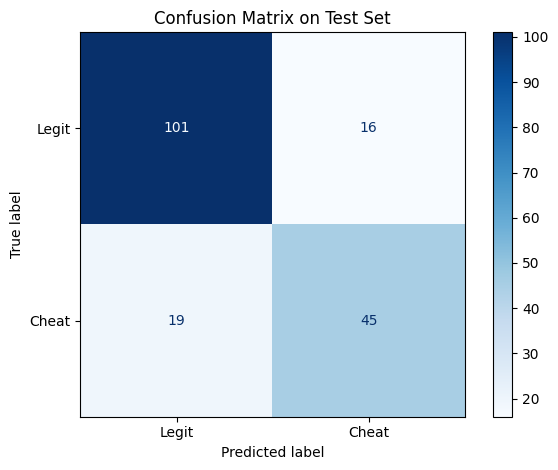

In [11]:
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(cm, display_labels=["Legit", "Cheat"])
plt.figure(figsize=(4, 4))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix on Test Set")
plt.tight_layout()
plt.show()